# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries 
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!

- 🤝 Breakout Room #2:
  1. Evaluating the LangGraph Application with LangSmith
  2. Adding Helpfulness Check and "Loop" Limits
  3. LangGraph for the "Patterns" of GenAI

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies


## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [1]:
#import os
#import getpass
#
#os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
# os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
# os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

True

In [3]:

# from langchain_openai import ChatOpenAI
# from langchain_core.prompts import ChatPromptTemplate
# from langchain_core.output_parsers import StrOutputParser

# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are a helpful assistant that can answer questions and help with tasks."),
# ])

# chain = prompt | llm | StrOutputParser()

# response = chain.invoke({"input": "What is the capital of France?"})

# print(response)

In [4]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE7 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = os.environ.get("LANGSMITH_API_KEY")
print("✅ OpenAI Key:", "SET" if os.environ.get("OPENAI_API_KEY") else "❌ MISSING")
print("✅ Tavily Key:", "SET" if os.environ.get("TAVILY_API_KEY") else "❌ MISSING")  
print("✅ LangSmith Key:", "SET" if os.environ.get("LANGCHAIN_API_KEY") else "❌ MISSING")

✅ OpenAI Key: SET
✅ Tavily Key: SET
✅ LangSmith Key: SET


## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain-community/tree/main/libs/community) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Tavily Search Results](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/tavily_search/tool.py)
- [Arxiv](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/arxiv/tool.py)

#### 🏗️ Activity #1:

Please add the tools to use into our toolbelt.

> NOTE: Each tool in our toolbelt should be a method.

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tavily_tool = TavilySearchResults(max_results=5)

tool_belt = [
    tavily_tool,
    ArxivQueryRun(),
]

/tmp/ipykernel_113505/1203815797.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [6]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [7]:
model = model.bind_tools(tool_belt)

#### ❓ Question #1:

How does the model determine which tool to use?  

### ✅ Answer #1   
The model determines which tool to use through the OpenAI function calling API. Here's how:
```python
# The model analyzes the user query and decides which tool to call
model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)
model = model.bind_tools(tool_belt)  # Binds available tools

# When invoked (see further down the code) the model returns tool_calls if it needs to use tools
response = model.invoke(messages)
if response.tool_calls:
    # Model decided to use a tool
    tool_name = response.tool_calls[0]['name']
```

The model uses the tool descriptions and function signatures to make this decision automatically.
We provided the tool descriptions in the list tool_belt and passed it with model.bind_tools(toolbelt).

## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [8]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [9]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

tool_node = ToolNode(tool_belt)

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [10]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [11]:
uncompiled_graph.set_entry_point("agent")

<!-- ![image](https://i.imgur.com/wNixpJe.png) /-->

<p align="center">
<img src="https://i.imgur.com/wNixpJe.png" width=45%/>
</p>

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a `"function_call" kwarg` present. 
 New way is below in the code: `if last_message.tool_calls:`   


#### Looking for: where our function simply checks if there is a `"function_call" kwarg` present." 

Claude explained: You're seeing BOTH locations for tool calls:  
The data IS in additional_kwargs, but the code uses the processed version!  
You're seeing BOTH locations for tool calls:
```Python
AIMessage(
    additional_kwargs={'tool_calls': [...]},  # ← Raw OpenAI API response
    tool_calls=[...]                          # ← LangChain's processed version
)
```
What's Happening:  
OpenAI API returns tool calls in additional_kwargs['tool_calls']  
LangChain processes this and ALSO puts it in the direct tool_calls attribute  
The code checks last_message.tool_calls (LangChain's processed version)  
But the raw data is still in additional_kwargs (OpenAI's original format)  
The data IS in additional_kwargs, but the code uses the processed version!


 AIMessage datastructure: 
```Python
AIMessage(
    content='',                           # Main message content
    additional_kwargs={                   # Raw API response data. We can add other kwargs
        'tool_calls': [...],
        'refusal': None
    },
    response_metadata={                   # API metadata
        'token_usage': {...},
        'model_name': 'gpt-4.1-nano-2025-04-14',
        'system_fingerprint': None,
        'id': 'chatcmpl-...',
        'service_tier': 'default',
        'finish_reason': 'tool_calls',
        'logprobs': None
    },
    id='run--...',                       # LangChain run ID
    tool_calls=[...],                    # Processed tool calls
    usage_metadata={...}                 # Token usage info
)
```
ToolMessage Data Structure:  
```Python
ToolMessage(
    content='[result data]',             # Tool execution result
    name='tavily_search_results_json',   # Tool name
    id='unique-id',                      # Message ID
    tool_call_id='call_...',            # Links to AIMessage tool_call
    artifact={...}                       # Additional tool data
)
```   
Can You Add Other Items?   
✅ YES! You can extend through:  
1. additional_kwargs (most common):

    ```Python
    class BaseMessage:
        content: str                    # Message content
        additional_kwargs: dict         # Extra data
        response_metadata: dict         # API metadata
        id: str                        # Message ID
        # ... other fields
    ```

2. Custom Message Classes:
    ```Python
    ai_message = AIMessage(
        content="Hello",
        additional_kwargs={
            "custom_field": "my_value",
            "user_id": "123",
            "timestamp": "2024-01-01"
        }
    )
    ```

3. Response Metadata:

```Python
    from langchain_core.messages import BaseMessage

    class CustomMessage(BaseMessage):
        special_field: str
        user_data: dict
        
        @property
        def type(self) -> str:
            return "custom"
    ```


🎯 Summary:
Discrepancy: Both formats exist - raw (additional_kwargs) + processed (tool_calls)  
Items: Content, metadata, IDs, tool calls, usage data  
Customizable: Yes, via additional_kwargs or custom classes  
The code works because it uses the processed tool_calls attribute, not the raw additional_kwargs  

Your observation reveals the layered nature of LangChain's message system!

=======================================================================================================  

Then we create an edge where the origin node is our agent node and our destination node is *either* the `action` node or the `END` (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [12]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls: 
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

Let's visualize what this looks like.

<!-- ![image](https://i.imgur.com/8ZNwKI5.png) /-->
<p align="center">
  <img src="https://i.imgur.com/8ZNwKI5.png" width="50%" />
</p>


Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [13]:
uncompiled_graph.add_edge("action", "agent")

All that's left to do now is to compile our workflow - and we're off!

In [14]:
simple_agent_graph = uncompiled_graph.compile()

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?

If not, how could we impose a limit to the number of cycles?

##### ✅ Answer #2:  
No specific limit, but we have to use some criterion to stop it, as:  
 * number of cycles (recursion limit, i.e. # iterations)  
 * Use a conditional_edge with some specific metric, e.g. if the answer is not satisfactory within that condition. e.g.:  
 
    ```python
    def should_continue(state: MyState) -> str:
        if state.loop_condition_met:  # Example termination condition
            return "end"
        else:
            return "my_node"  # Continue the loop
    ```
 * Set a time limit by: 
    * setting the `max_execution_time` parameter in the `AgentExecutor` configuration
    * Implementing custom timeouts within nodes
    * Checking elapsed time within conditional edges (as shown above)
 * Human_in_the_loop (Interrupts, Breakpoints). 
   * Use `interrupt()` function inside a node


To minimize disruptiveness in using time limits and handle timeouts gracefully:  
* Use early_stopping_method: 
    * When using AgentExecutor, you can set the early_stopping_method to "generate" to allow the agent to make one final attempt at generating an output before stopping.
* Implement error handling
* Provide meaningful error messages:
    * Route to a specific "fallback" node that can handle the situation if the time limit is exceeded
* Persistence in resumption (for human_in_the_loop), uses LangGraph's persistence layer


## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [15]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="Who is the current captain of the Winnipeg Jets?")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lr7UFcRBHZ98vOECGHLqYDY5', 'function': {'arguments': '{"query":"current captain of the Winnipeg Jets"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 162, 'total_tokens': 185, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BtYpl043g61ysXR5qPlFaAJHn6Con', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--315c413c-44a3-45ea-9839-cdad617b4779-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current captain of the Winnipeg Jets'}, 'id': 'call_lr7UFcRBHZ98vOECGHLqYDY5', 'type': 

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [16]:
inputs = {"messages" : [HumanMessage(content="Search Arxiv for the QLoRA paper, then search each of the authors to find out their latest Tweet using Tavily!")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])

        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tSTkvZqcVPAjjpeH6ODye1xJ', 'function': {'arguments': '{"query": "QLoRA"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_rQHgivMKtPOeoobuErQ3OOu5', 'function': {'arguments': '{"query": "latest Tweet of author"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 178, 'total_tokens': 232, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BtYprHPmXUdbLkDvSrROnHAYxz7fG', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--afcc4a26-68f4-41fe-a202-324564744a5d-0', tool_calls=[{'name': 'arxiv', 'args': {'que

#### 🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.    

I asked Why "updates" is Useful:  
passed in: async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates")

- ✅ Real-time feedback - See agent thinking step-by-step  
- ✅ Debug friendly - Spot where things go wrong
- ✅ User experience - Shows progress instead of waiting


Here is where we insert the decision edge noting:  
1. from which node it starts and 
2. that it has to make a decision `should_continue` 
```Python
uncompiled_graph.add_conditional_edges(
    "agent",           # FROM this node
    should_continue    # USE this function to decide
)
```




1. Our state object was populated with our request  
2. The state object was passed into the entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge    
&emsp;  

3. The conditional edge containing `if node is action` received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
 It receives an AIMesage containing the state object:  
 Receiving update from node: 'agent'  
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YNClje2h5JTcIHjCJmGcb1lY', 'function': {'arguments': '{"query": "QLoRA"}', 'name': 'arxiv'}, 'type': 'function'},...   

4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node:    
Receiving update from node: 'action' To use a tool arxiv and go check arxiv website.   
Tool Used: arxiv<br>
 The agent uses the tool and retrieves the contents from this paper:   
 [ToolMessage(content='Published: 2023-05-23\nTitle: QLoRA: Efficient Finetuning of Quantized LLMs\nAuthors:     
 ...response_time': 3.99})]    
   
5. The agent node added a response to the state object and passed it along the conditional edge:  
Receiving update from node: 'agent', and sends response to end node:   
 [AIMessage(content='I found the QLoRA paper on arXiv, titled "QLoRA: Efficient Finetuning of Quantized LLMs," authored by  

6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!
Receiving update from node: 'agent'
[AIMessage(content='I found the QLoRA paper on arXiv,...   
... additional_kwargs={'refusal': None}, ...]*   

# 🤝 Breakout Room #2

## Part 1: LangSmith Evaluator

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [17]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
  return input_state["messages"][-1].content

agent_chain_with_formatting = convert_inputs | simple_agent_graph | parse_output

In [18]:
agent_chain_with_formatting.invoke({"question" : "What is RAG in LLMs?"}) # I added "in LLMs" because without it the LLM generates ansers unrelated to retrieval generation.

"RAG in the context of Large Language Models (LLMs) stands for Retrieval-Augmented Generation. It is a technique that combines the generative capabilities of LLMs with external knowledge retrieval systems to improve the accuracy and relevance of the generated responses.\n\nIn RAG, the model retrieves relevant documents or information from an external knowledge base or document store and then uses this retrieved information to generate more informed and contextually accurate responses. This approach helps overcome the limitations of LLMs' fixed training data and enables them to provide up-to-date and factually accurate information.\n\nWould you like a more detailed explanation or information on how RAG is implemented?"

### Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

#### 🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

In [19]:
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system in LLMs?",# this is a tricky one, as the answer is not specific to the question, so I added in LLMs. 
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make in LLMs ?" # this is a tricky one, as the answer is not specific to the question, so I added in LLMs. 
]

answers = [
    {"must_mention" : ["paged", "optimizer"]}, # paged is the optimizer. 
    {"must_mention" : ["NF4", "NormalFloat"]}, # NF4 is acronym for the datatype NormalFloat. 4 denotes the number of bits.
    {"must_mention" : ["ground", "context","RAG"]}, # the context is the ground truth, but the question is not specific to the context, namely the RAG.
    {"must_mention" : ["Tim", "Dettmers"]}, # Tim Dettmers is the author of the QLoRA paper
    {"must_mention" : ["PyTorch", "TensorFlow"]}, # PyTorch and TensorFlow are the most popular deep learning frameworks
    {"must_mention" : ["reduce", "parameters"]}, # LoRA reduces the number of parameters, but the question is not specific to the LoRA system.
]

Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [20]:
from langsmith import Client

client = Client()

dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers, # the answers are the ground truth
    dataset_id=dataset.id,
)

{'example_ids': ['ace2e8e2-21b6-4f55-be65-9bfc4da8b2f4',
  '033ab312-29b3-481e-8b7c-0be7812b187f',
  'e33beaef-535b-4111-9667-c2c70f347b44',
  '324fb932-585c-4c85-bea7-955de3209820',
  '5d6109a3-dfe3-4cea-96fc-bd73dcaad1dd',
  '37a3bbbe-fed7-4a4a-96f1-10be2141fbcf'],
 'count': 6}

#### ❓ Question #3:


How are the correct answers associated with the questions?

> NOTE: Feel free to indicate if this is problematic or not
#### ✅ Answer #3:
The correct answers are sequentialy associated with the questions within the dataset's examples.  
They follow the same sequence: 1->1, 2->2, etc.   
There may be a problem when evaluating LLM outputs where there might be multiple possible "correct" answers,  
 or when comparing the outputs of two different LLM applications (e.g., in pairwise evaluation).
<!--  In Pairwise evaluation, LLMs can exhibit <mark>Positional Bias</mark>, where the LLM favors responses in e.g., first or last positions  /-->
 In Pairwise evaluation, LLMs can exhibit <span style="background-color:cyan">MPositional Bias</span>, where the LLM favors responses in e.g., first or last positions  
 For this case LangSmith provides the option to randomize the order of the outputs for each pairwise evals.  
 Or, Add in the prompt to "avoid positional bias"


### Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [21]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

#### ❓ Question #4:

What are some ways you could improve this metric as-is?   
#### ✅ Answer #4:
As we see when we run the test below, the LLM can get sidetracked if neither the question, nor the answer are specific   
to what we want to retrieve, since there may be more than one responses acceptable to match the keywords.   
To improve it we need to add more specifics both to the question and to the list of keywords in the must_mention.

> NOTE: Alternatively you can suggest where gaps exist in this method.
#### GAPS formed from using LLMs as evaluators  
* Reliance on Golden QA Sets and Subjectivity
* Limitations of Traditional Metrics like ROUGE and BLEU which may not aligh with human judgement
* Bias in LLM-as-Judge Evaluation, as e.g., preferences for their own outputs,  
size of responses, scoring, etc. Combine with RAGAS evaluation
* Evaluating Complex QA Workflows (e.g., RAG) requiring assessment of both the retrieval  
and the generation steps with specialized metrics.
* Generating Diverse and Representative Datasets: If synthetic dat is used, it is advisable  
to have a hand-crafted examples, to ensure diversity and representativeness in the synthetic data.

Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [22]:
experiment_results = client.evaluate(
    agent_chain_with_formatting,
    data=dataset_name,
    evaluators=[must_mention],
    experiment_prefix=f"Search Pipeline - Evaluation - {uuid4().hex[0:4]}",
    metadata={"version": "1.0.0"},
)

View the evaluation results for experiment: 'Search Pipeline - Evaluation - d7a7-90fa86c4' at:
https://smith.langchain.com/o/74b9e486-2e11-541b-b227-c9c177f98636/datasets/9996ad36-111a-4662-ac31-a4e87fbe83b3/compare?selectedSessions=f2a1b984-5270-4276-bdb2-973deca63bf7




0it [00:00, ?it/s]

In [23]:
experiment_results

<ExperimentResults Search Pipeline - Evaluation - d7a7-90fa86c4>

## Part 2: LangGraph with Helpfulness:

### Task 3: Adding Helpfulness Check and "Loop" Limits

Now that we've done evaluation - let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add to our existing conditional edge to obtain the behaviour we desire.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [24]:
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

#### 🏗️ Activity #5:

Please write markdown for the following cells to explain what each is doing.

##### YOUR MARKDOWN HERE
The following cell, just like with the uncompiled_graph above, initiates a StateGraph with an AgentState.   
Then we add 2 nodes, the   
"agent" node which will call a model, and the   
"action" node, which is the tool_node, i.e. it specifies the tools that the agent will use to do the action.

In [25]:
graph_with_helpfulness_check = StateGraph(AgentState)

graph_with_helpfulness_check.add_node("agent", call_model)
graph_with_helpfulness_check.add_node("action", tool_node)

##### YOUR MARKDOWN HERE
The following defines in which node the flow starts: in this case it starts in the "agent" node

In [26]:
graph_with_helpfulness_check.set_entry_point("agent")

##### YOUR MARKDOWN HERE
In the following cell we create the tool tool_call_or_helpful(state) which will be used in a cycle of max 10 rounds.   
We use a chain to pass the prompt_template to the model whose final_response goes into the outout parser.
We set the condition Y for the conditional edge "should_continue" for the flow to connect either to the END node or else to repeat the cycle 

In [27]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def tool_call_or_helpful(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  if len(state["messages"]) > 10:
    return "END"

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  helpfullness_prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4.1-mini")

  helpfulness_chain = helpfullness_prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    return "end"
  else:
    return "continue"

#### 🏗️ Activity #4:

Please write what is happening in our `tool_call_or_helpful` function!

##### YOUR MARKDOWN HERE
We create the tool `tool_call_or_helpful` function where:  
-  we define a sequence of events in a with max 10 rounds.  
- We use a chain to pass the prompt_template to the model whose final_response  
goes into the outout parser.   
- We set the condition Y for the conditional edge "should_continue" for the flow to  
 connect either to the END node or else to repeat the cycle.


 In the next cell we continue building the graph by adding a conditional_edge which uses   
 the function `tool_call_or_helpful` to make the decision to continue the cycle by going into the "action" node   
 or end the cycle by going to the "END" node.

In [28]:
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    tool_call_or_helpful,
    {
        "continue" : "agent",
        "action" : "action",
        "end" : END
    }
)

##### YOUR MARKDOWN HERE
Next we add the edge from the "action" node to the "agent" node

In [29]:
graph_with_helpfulness_check.add_edge("action", "agent")

##### YOUR MARKDOWN HERE
Now we compile our graph with `.compile` method, meaning converting the stateful workflow into a runnable format which returns   
➡️ a CompiledStateGraph object, ready to be executed.  
 It implements the LangChain Runnable interface, allowing us to interact with it using methods like .invoke(), .stream(), and .batch()

In [30]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

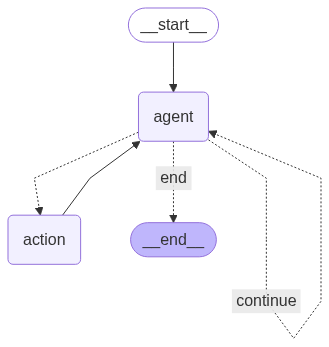

In [ ]:
agent_with_helpfulness_check # Prints the graph

##### YOUR MARKDOWN HERE
Next we test our graph "agent_with_helpfulness_check" by asynchronously iterating over the chunks (`.astream()`),   
i.e. for every chunk of our document, by giving it as input our human query, and letting it update the state of the nodes in each cycle.

In [31]:
inputs = {"messages" : [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}

async for chunk in agent_with_helpfulness_check.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UhYyajIaYtTKehCbFmNWIcnW', 'function': {'arguments': '{"query": "LoRA machine learning"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_6O7GPIhB5j8ALgj3dCwAj53F', 'function': {'arguments': '{"query": "Tim Dettmers"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_QnxUCC6uRGKuVVJJaLds9nJp', 'function': {'arguments': '{"query": "Attention in machine learning"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 177, 'total_tokens': 256, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BtY

### Task 4: LangGraph for the "Patterns" of GenAI

Let's ask our system about the 4 patterns of Generative AI:

1. Prompt Engineering
2. RAG
3. Fine-tuning
4. Agents

In [32]:
patterns = ["prompt engineering", "RAG", "fine-tuning", "LLM-based agents"]

In [33]:
for pattern in patterns:
  what_is_string = f"What is {pattern} and when did it break onto the scene??"
  inputs = {"messages" : [HumanMessage(content=what_is_string)]}
  messages = agent_with_helpfulness_check.invoke(inputs)
  print(messages["messages"][-1].content)
  print("\n\n")

Prompt engineering is the process of designing and refining input prompts to effectively communicate with AI language models, such as GPT, to elicit accurate, relevant, and useful responses. It involves crafting prompts in a way that guides the model to produce desired outputs, often through techniques like specifying context, framing questions clearly, and using examples.

Prompt engineering gained prominence with the rise of large language models (LLMs) around 2020-2021, as users and developers recognized the importance of prompt design in maximizing the utility of these models. The practice became especially prominent with the release of models like GPT-3 in 2020, which demonstrated significant capabilities but also required careful prompt formulation to achieve optimal results.

Would you like more detailed information on its history or specific techniques?



RAG, which stands for Retrieval-Augmented Generation, is a technique in natural language processing that combines pre-train